In [1]:
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import numpy as np


def create_jittered_points(gridsize: int, jitter: float, min_value: int=0) -> np.array:
    """
    Generates a set of points on a grid with specified jitter.
    
    Parameters:
        gridsize (int): The size of the grid.
        jitter (float): The amount of jitter to apply to each point.
        min_value (int): The minimum value of x and y coordinates in the grid.
    
    Returns:
        np.array: An array of points with applied jitter.
    """
    points = []
    for x in range(min_value, gridsize + 1):
        for y in range(min_value, gridsize + 1):
            jitter_x = jitter * (np.random.rand() - np.random.rand())
            jitter_y = jitter * (np.random.rand() - np.random.rand())
            points.append((x + jitter_x, y + jitter_y))
    return np.array(points)

In [2]:
MIN_VALUE = 0
GRIDSIZE = 25
JITTER = 0.5

points = create_jittered_points(GRIDSIZE, JITTER, MIN_VALUE)

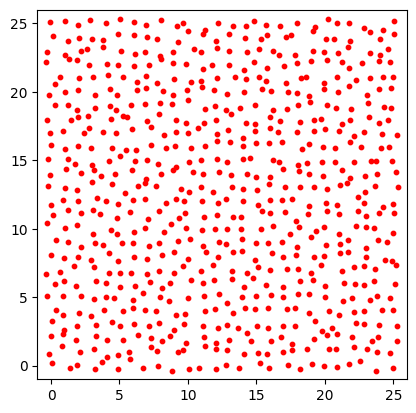

In [3]:
def plot_points(points: np.array, gridsize: int, min_value: int = 0) -> None:
    """
    Plots points on a scatter plot with a specific grid size and minimum value for the axes.
    
    Parameters:
        points (np.array): Array of points to plot.
        gridsize (int): The grid size to scale the plot dimensions.
        min_value (int): Minimum value for the plot's x and y axes.
    """
    fig, ax = plt.subplots()
    ax.scatter(points[:, 0], points[:, 1], color='red', s=10)  # s is the marker size
    ax.set_aspect('equal', adjustable='box')  # Keeps the x and y scale the same
    plt.xlim(min_value - 1, min_value + gridsize + 1)
    plt.ylim(min_value - 1, min_value + gridsize + 1)
    plt.show()

plot_points(points, GRIDSIZE, MIN_VALUE)

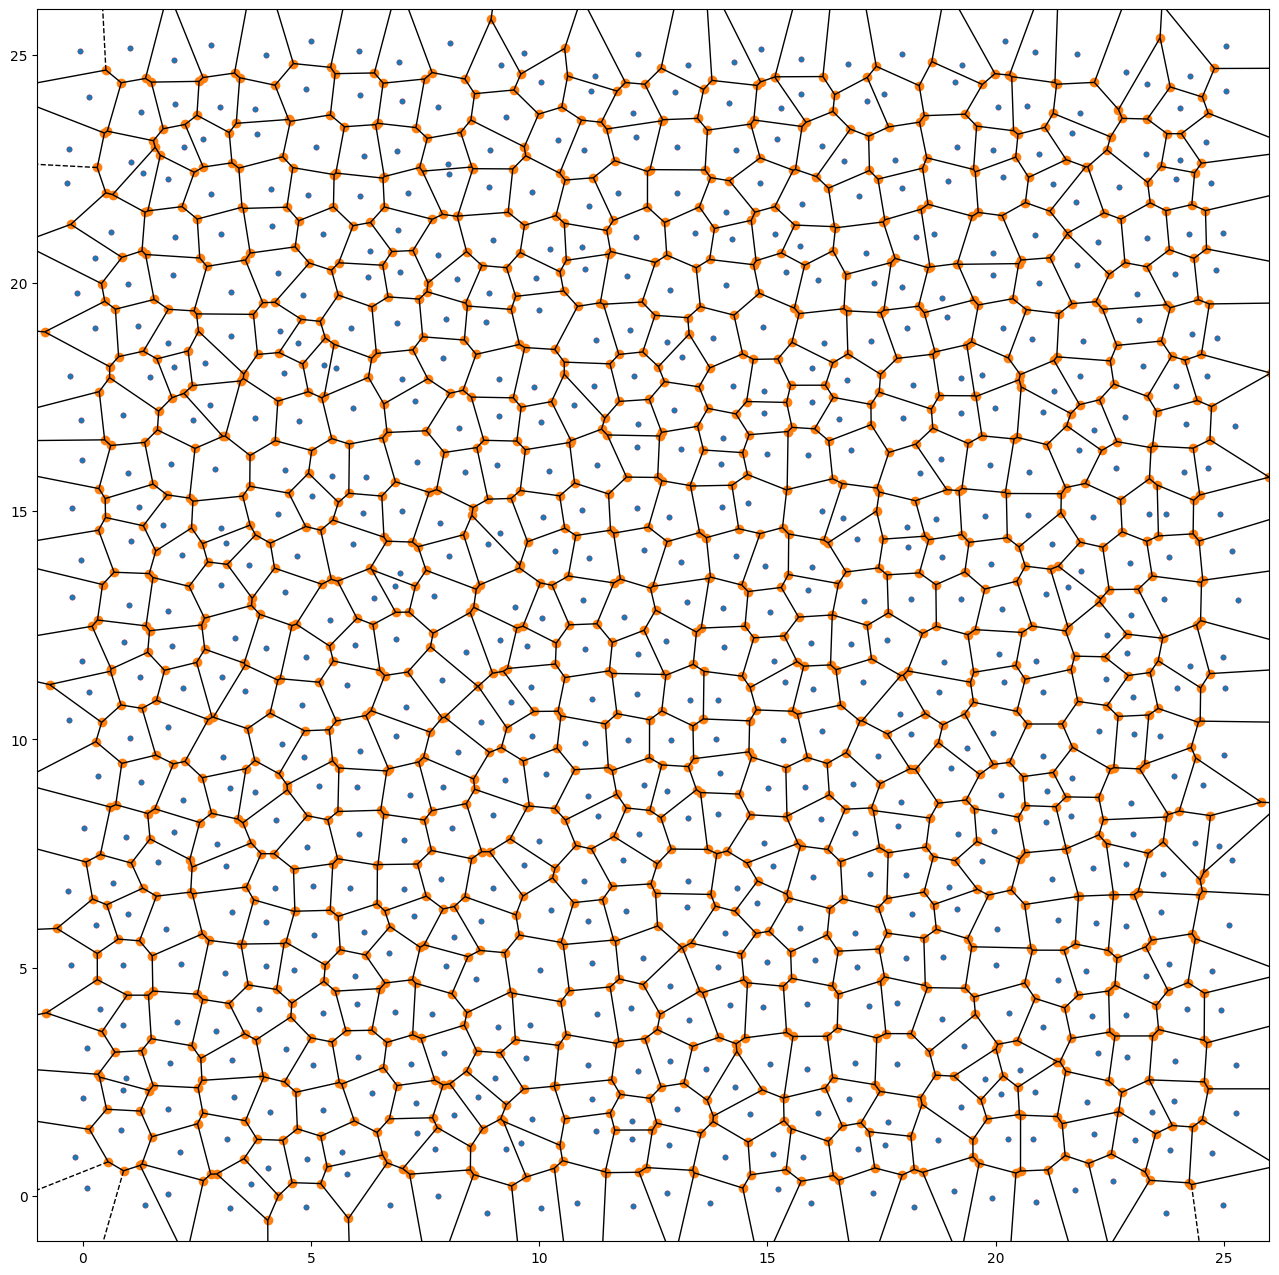

In [4]:
def plot_delaunay(points: np.array, gridsize: int, min_value: int = 0) -> None:
    """
    Plots Delaunay triangulation on a scatter plot with a specific grid size and minimum value for the axes.
    
    Parameters:
        points (np.array): Array of points to plot.
        gridsize (int): The grid size to scale the plot dimensions.
        min_value (int): Minimum value for the plot's x and y axes.
    """
    triangulation = Delaunay(points)
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.scatter(points[:, 0], points[:, 1], color='red', s=10)  # s is the marker size
    ax.set_aspect('equal', adjustable='box')  # Keeps the x and y scale the same
    voronoi_plot_2d(Voronoi(points), ax=ax)
    plt.xlim(min_value - 1, min_value + gridsize + 1)
    plt.ylim(min_value - 1, min_value + gridsize + 1)
    plt.show()

plot_delaunay(points, GRIDSIZE, MIN_VALUE)

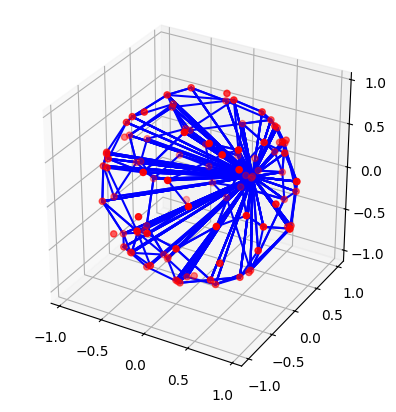

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

def generate_points_on_sphere(num_points, radius=1):
    points = []
    for _ in range(num_points):
        phi = np.random.uniform(0, np.pi*2)  # Longitude angle
        cos_theta = np.random.uniform(-1, 1)  # Cosine of the latitude angle
        theta = np.arccos(cos_theta)  # Latitude angle
        
        x = radius * np.sin(theta) * np.cos(phi)
        y = radius * np.sin(theta) * np.sin(phi)
        z = radius * cos_theta
        
        points.append((x, y, z))
    return np.array(points)

def plot_delaunay_3d(points):
    """
    Plots Delaunay triangulation for 3D points on a sphere.
    """
    # Delaunay triangulation
    delaunay = Delaunay(points)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='red')
    
    # Plot the Delaunay triangulation
    for simplex in delaunay.simplices:
        tri = points[simplex]  # Triangle vertices
        # Draw lines between the vertices
        for i in range(3):
            start, end = tri[i], tri[(i + 1) % 3]
            ax.plot3D(*zip(start, end), color='b')
    
    # Equal aspect ratio
    ax.set_box_aspect([1,1,1])
    plt.show()

# Parameters
num_points = 100  # Number of points to generate on the sphere
radius = 1  # Radius of the sphere

# Generate points
points = generate_points_on_sphere(num_points, radius)

# Plot 3D Delaunay triangulation
plot_delaunay_3d(points)


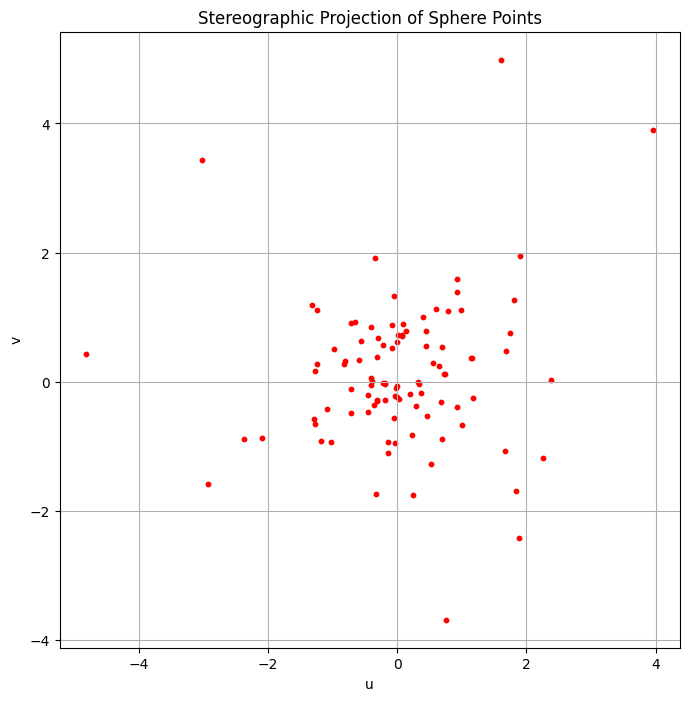

In [6]:
def stereographic_projection(points):
    """
    Projects points on a sphere onto a plane using stereographic projection from the north pole.

    Parameters:
        points (np.array): Array of points (x, y, z) on the sphere.

    Returns:
        np.array: Projected points in 2D (u, v).
    """
    # Projection from the north pole (0, 0, 1)
    projected_points = []
    for x, y, z in points:
        # Avoid division by zero by offsetting z slightly
        denominator = 1 - z if z != 1 else 0.9999
        u = x / denominator
        v = y / denominator
        projected_points.append((u, v))
    return np.array(projected_points)

projected_points = stereographic_projection(points)
# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(projected_points[:, 0], projected_points[:, 1], color='red', s=10)
plt.xlabel('u')
plt.ylabel('v')
plt.title('Stereographic Projection of Sphere Points')
plt.axis('equal')
plt.grid(True)
plt.show()


In [11]:
from ursina import *
from typing import List, Tuple

class TerrainFace:
    def __init__(self, mesh: Mesh, resolution: int, local_up: Vec3) -> None:
        self.mesh: Mesh = mesh
        self.resolution: int = resolution
        self.local_up: Vec3 = local_up

        self.axis_a: Vec3 = Vec3(local_up.y, local_up.z, local_up.x)
        self.axis_b: Vec3 = Vec3.cross(local_up, self.axis_a)

    def construct_mesh(self) -> None:
        vertices: List[Vec3] = []
        triangles: List[int] = []

        for y in range(self.resolution):
            for x in range(self.resolution):
                i: int = x + y * self.resolution
                percent: Vec2 = Vec2(x, y) / (self.resolution - 1)
                point_on_unit_cube: Vec3 = (self.local_up +
                                            (self.axis_a * (percent.x - .5) * 2) +
                                            (self.axis_b * (percent.y - .5) * 2))
                point_on_unit_sphere: Vec3 = point_on_unit_cube.normalized()
                vertices.append(point_on_unit_sphere)

                if x != self.resolution - 1 and y != self.resolution - 1:
                    triangles.extend([i, i + self.resolution + 1, i + self.resolution,
                                      i, i + 1, i + self.resolution + 1])

        self.mesh.vertices = vertices
        self.mesh.triangles = triangles
        self.mesh.uvs = [Vec2(0, 0) for _ in vertices]
        self.mesh.generate_normals()

# Usage in an Ursina application
if __name__ == '__main__':
    app = Ursina()

    mesh = Mesh()
    terrain_face = TerrainFace(mesh, 10, Vec3(1, 0, 0))
    terrain_face.construct_mesh()

    entity = Entity(model=mesh)
    EditorCamera()
    app.run()


os: Darwin
development mode: True
application successfully started
* interrupt by keyboard
